# Lego classification using CNN

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Open the files:
train_fh = open('/Users/skyrex/Desktop/my/учеба/прога/neural networks course spbu/lego pieces classification/lego-train.pickle', 'rb')
test_fh = open('/Users/skyrex/Desktop/my/учеба/прога/neural networks course spbu/lego pieces classification/lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_dataloader = pickle.load(train_fh)
test_dataloader = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [3]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', 
               '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth',
               '1x2 Handles', '1x2 Grill']


In [4]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [5]:
class LegoDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
import torchvision.transforms as transforms

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.13, 0.31)
])

train_dataset = LegoDataset(train_dataloader, tfs)
test_dataset = LegoDataset(test_dataloader, tfs)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [31]:
def label2text(label):
    if not isinstance(label, int):
        label = label.item()
        
    return class_names[label]

In [40]:
def show_random(test_dataloader):
    n = len(test_dataloader)
    index = np.random.randint(0, n)
    
    img, label = test_dataloader.dataset[index]
    label = label2text(label)
    np_img = img.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    np_img = np.squeeze(np_img)
    
    plt.imshow(np_img)
    plt.title(label)
    

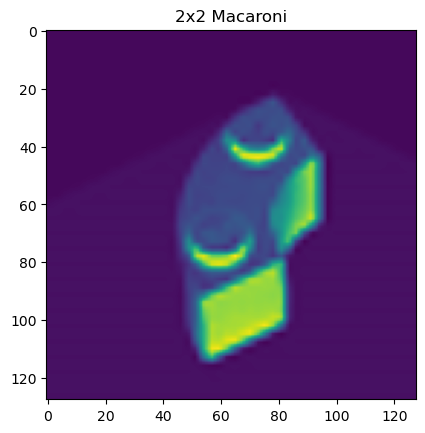

In [42]:
show_random(test_dataloader)

## CNN implementation

In [43]:
import torch
from torch import nn

### Building model

In [44]:
class MyCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.linear = nn.Sequential(
            nn.Linear(in_features=29*29*16, out_features=5000),
            nn.BatchNorm1d(num_features=5000),
            nn.ReLU(),
            nn.Linear(in_features=5000, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)

        x = x.reshape(-1, 16*29*29)

        return self.linear(x)

### Training model

In [45]:
from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [47]:
def train(model, optim, criterion, train_dataloader, test_dataloader, num_epochs=10):
    losses = {'train': [], 'test': []}
    train_n_iter = 0
    test_n_iter = 0
    
    # writer = SummaryWriter()
    for epoch in tqdm(range(num_epochs), desc="Epoch"):

        model.train()
        train_loss = 0

        for X_batch, y_batch in train_dataloader:
            optim.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optim.step()
            train_loss += loss.item()
            # writer.add_scalar('Loss/train', loss.item(), train_n_iter)
            train_n_iter += 1
                
        losses['train'].append(train_loss / len(train_dataloader))

        model.eval()
        test_loss = 0
        for X_batch, y_batch in test_dataloader:
            with torch.no_grad():
                y_pred = model(X_batch.to(device))
                
            loss = criterion(y_pred, y_batch.to(device))
            test_loss += loss.item()
            # writer.add_scalar('Loss/test', loss.item(), test_n_iter)
            test_n_iter += 1
        
        losses['test'].append(test_loss / len(test_dataloader))

        print(f'Epoch: {epoch + 1}/{num_epochs}; train_loss: {train_loss}; test_loss: {test_loss}')
        
    plt.plot(losses['train'], label='train loss')
    plt.plot(losses['test'], label='test loss')
    plt.legend()
    
    return losses

                    

In [48]:
model = MyCNN().to(device)

optim = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Epoch:  10%|█         | 1/10 [00:10<01:35, 10.58s/it]

Epoch: 1/10; train_loss: 16.302069634199142; test_loss: 7.656235098838806


Epoch:  20%|██        | 2/10 [00:19<01:16,  9.61s/it]

Epoch: 2/10; train_loss: 4.944256631657481; test_loss: 3.8160475492477417


Epoch:  30%|███       | 3/10 [00:28<01:03,  9.14s/it]

Epoch: 3/10; train_loss: 2.6055398862808943; test_loss: 0.3392556682229042


Epoch:  40%|████      | 4/10 [00:36<00:53,  8.94s/it]

Epoch: 4/10; train_loss: 2.1219869134947658; test_loss: 0.3754312642849982


Epoch:  50%|█████     | 5/10 [00:45<00:45,  9.06s/it]

Epoch: 5/10; train_loss: 2.877334509976208; test_loss: 0.3076363876461983


Epoch:  60%|██████    | 6/10 [00:56<00:38,  9.50s/it]

Epoch: 6/10; train_loss: 3.6860529602854513; test_loss: 0.20058693177998066


Epoch:  70%|███████   | 7/10 [01:06<00:29,  9.83s/it]

Epoch: 7/10; train_loss: 4.273745991114993; test_loss: 18.40729832649231


Epoch:  80%|████████  | 8/10 [01:15<00:18,  9.48s/it]

Epoch: 8/10; train_loss: 7.370176139287651; test_loss: 0.06459430907852948


Epoch:  90%|█████████ | 9/10 [01:25<00:09,  9.53s/it]

Epoch: 9/10; train_loss: 4.641761327162385; test_loss: 0.15129041392356157


Epoch: 100%|██████████| 10/10 [01:34<00:00,  9.42s/it]

Epoch: 10/10; train_loss: 1.7675268664461328; test_loss: 0.02759218227583915


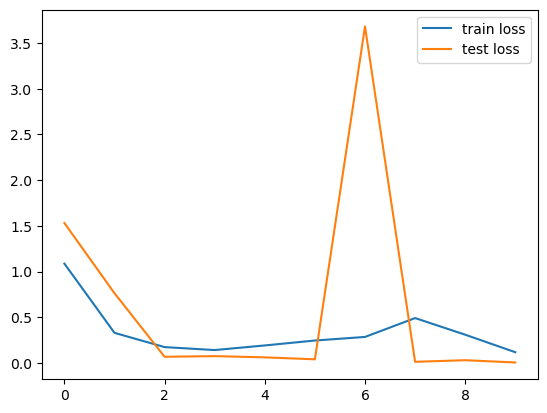

In [49]:
losses = train(model, optim, criterion, train_dataloader, test_dataloader, num_epochs=10)

###  Evaluate results

In [50]:
import itertools
from sklearn.metrics import accuracy_score

In [51]:
def accuracy(model, test_dataloader):
    model.eval()
    s = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch.to(device)).cpu().detach().numpy()
            y_pred = np.argmax(y_pred, axis=1)
            s += accuracy_score(y_batch.numpy(), y_pred)
            
    s /= len(test_dataloader)
    
    return s

In [52]:
print("Test accuracy:", accuracy(model, test_dataloader))

Test accuracy: 1.0


In [134]:
def predict_random(model, test_dataloader):
    model.eval()
    
    n = len(test_dataloader)
    index = np.random.randint(0, n)
    
    img, true_label = test_dataloader.dataset[index]
    true_label = label2text(true_label)
    img = img.unsqueeze(0)
    
    np_img = img.numpy()
    np_img = np.squeeze(np_img)
    
    with torch.no_grad():
        y_pred = np.argmax(softmax(model(img)).numpy())
    
    pred_label = label2text(y_pred)
    
    plt.imshow(np_img)
    if pred_label == true_label:
        plt.title(pred_label, fontdict={"color": "green"})
    else:
        plt.title(pred_label, fontdict={"color": "red"})

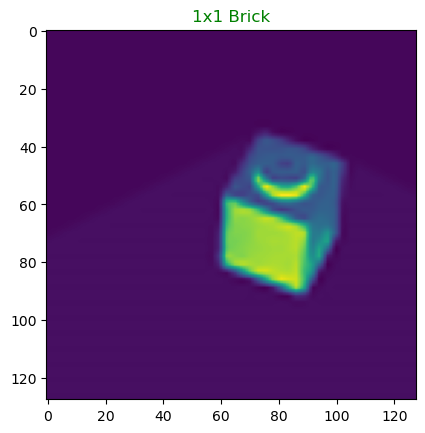

In [175]:
predict_random(model, test_dataloader)